In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

# Importing the DataSet

In [2]:
data = pd.read_csv("web_traffic.csv")
data

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737
...,...,...
4891,4891,2555880561
4892,4892,2454084459
4893,4893,2405182410
4894,4894,2356280361


# Data Exploration

In [3]:
data.shape

(4896, 2)

In [4]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [5]:
sessions = data['Sessions'].values

# Visualize the whole dataset

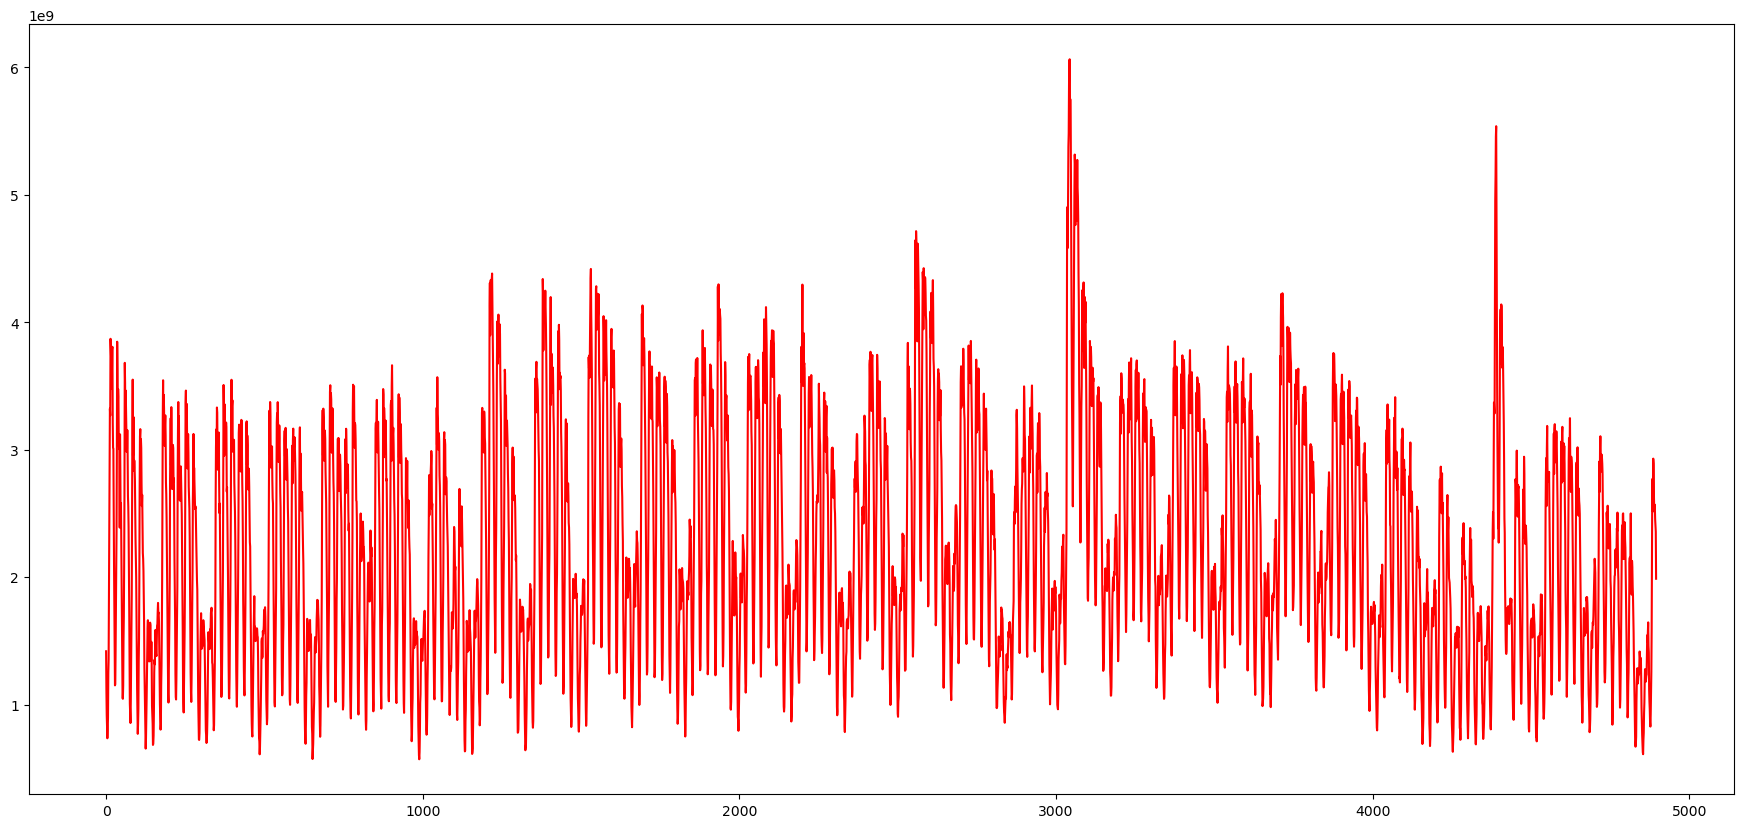

In [6]:
ar = np.arange(len(sessions))
plt.figure(figsize = (22,10))
plt.plot(ar, sessions, 'r')
plt.show()

# First week web traffic

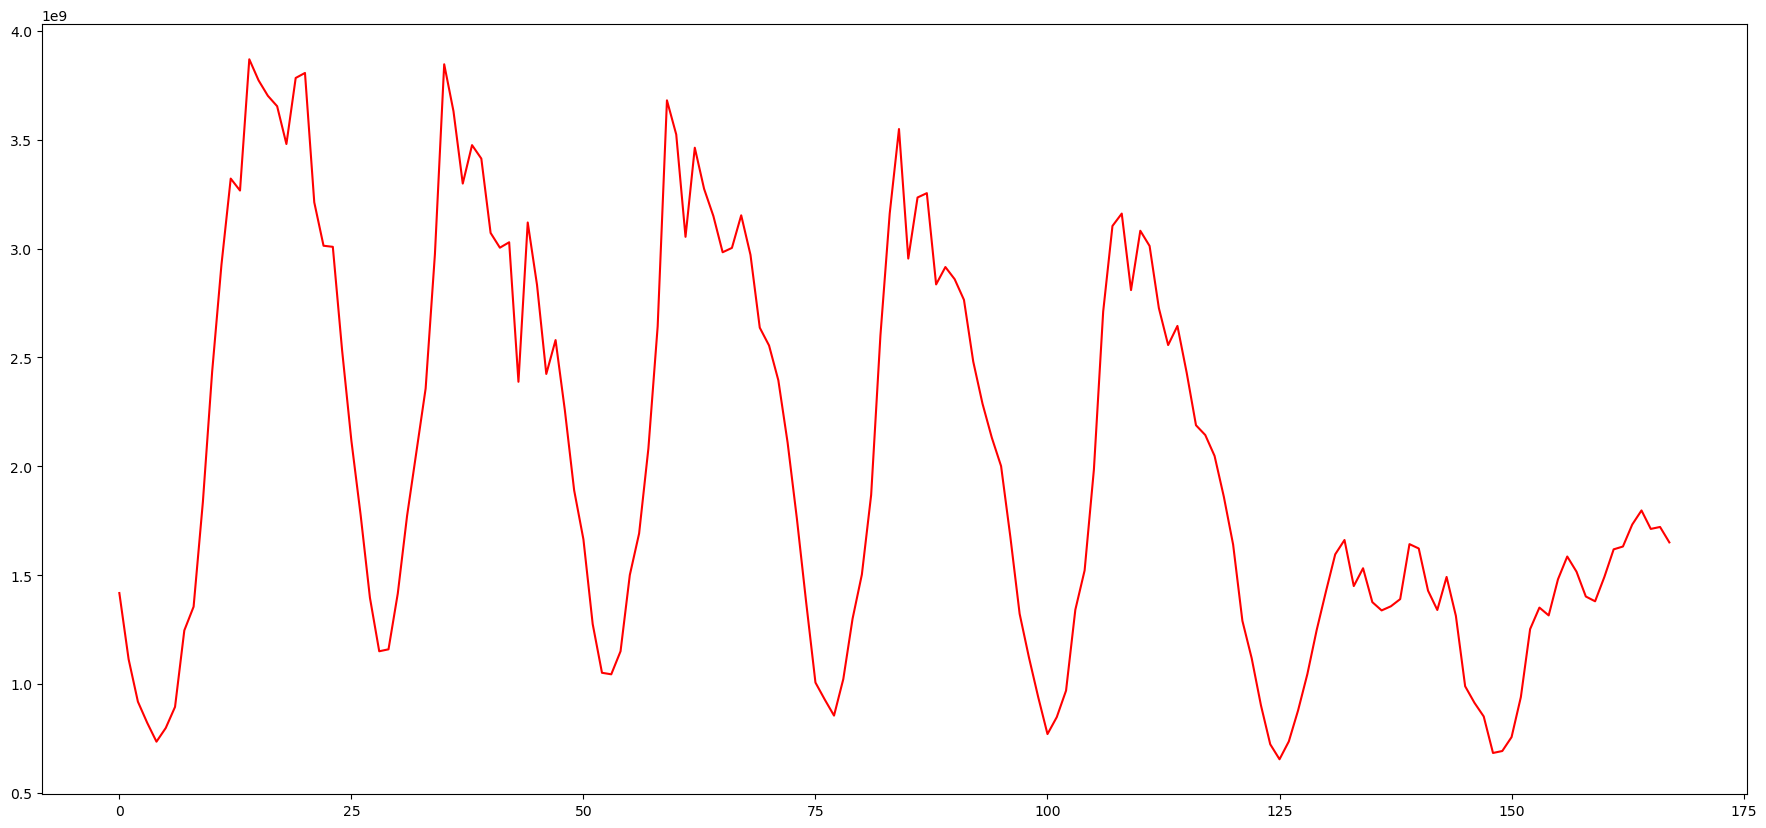

In [7]:
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize = (22,10))
plt.plot(ar, sample, 'r')
plt.show()

# Data Preparation

In [8]:
def prepare_data(seq, num):
    x = []
    y = []
    for i in range(0, (len(seq)- num), 1):
        input_ = seq[i:i+num]
        output = seq[i+num]
        
        x.append(input_)
        y.append(output)
    
    return np.array(x), np.array(y)

In [9]:
num = 168
x,y = prepare_data(sessions, num)
print(len(x))

4728


# Split the dataset

In [10]:
ind = int(0.9*len(x))

# prepare training and test data
X_train = x[:ind]
y_train = y[:ind]

X_test = x[ind:]
y_test = y[ind:]

# Scaling

In [11]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [12]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [13]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)[:, 0]
y_test = y_scaler.fit_transform(y_test)[:, 0]

In [14]:
#After that, we are reshaping the data from two dimensional to 3 dimensional
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)

(4255, 168, 1)


# Model building for web traffic forecasting

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape = (168,1)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74881 (292.50 KB)
Trainable params: 74881 (292.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(loss = 'mse', optimizer = 'adam')
mc = ModelCheckpoint('best_model.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = min)
# train the model

history = model.fit(X_train, y_train, epochs = 30, batch_size = 32,
                   validation_data = (X_test, y_test), callbacks = [mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1592
Epoch 1: val_loss improved from inf to 0.06840, saving model to best_model.hdf5


C:\Users\tanuj\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 35s 224ms/step - loss: 0.1592 - val_loss: 0.0684
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0431
Epoch 2: val_loss improved from 0.06840 to 0.04695, saving model to best_model.hdf5
133/133 [==============================] - 36s 270ms/step - loss: 0.0431 - val_loss: 0.0470
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0353
Epoch 3: val_loss improved from 0.04695 to 0.04373, saving model to best_model.hdf5
133/133 [==============================] - 31s 231ms/step - loss: 0.0353 - val_loss: 0.0437
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0325
Epoch 4: val_loss improved from 0.04373 to 0.04205, saving model to best_model.hdf5
133/133 [==============================] - 33s 245ms/step - loss: 0.0325 - val_loss: 0.0421
Epoch 5/30
133/133 [==============================] - ETA: 0s - loss: 0.0305
Epoch 5: val_loss did not improve from 0.04205
133/133 [================

In [18]:
model.load_weights('best_model.hdf5')

In [19]:
mse = model.evaluate(X_train, y_train)
print("Mean Square Error:",mse)

133/133 [==============================] - 16s 124ms/step - loss: 0.0143
Mean Square Error: 0.01425909623503685


# Forecasting

In [20]:
def Forecast(X_test, no_of_pred, ind):
    predictions = []
    temp = X_test[ind]
    for i in range(no_of_pred):
        pred = model.predict(temp.reshape(1,-1,1))[0][0]
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

In [21]:
no_of_pred = 24
ind = 72
y_pred = Forecast(X_test, no_of_pred, ind)
y_true = y_test[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 58ms/step


In [22]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

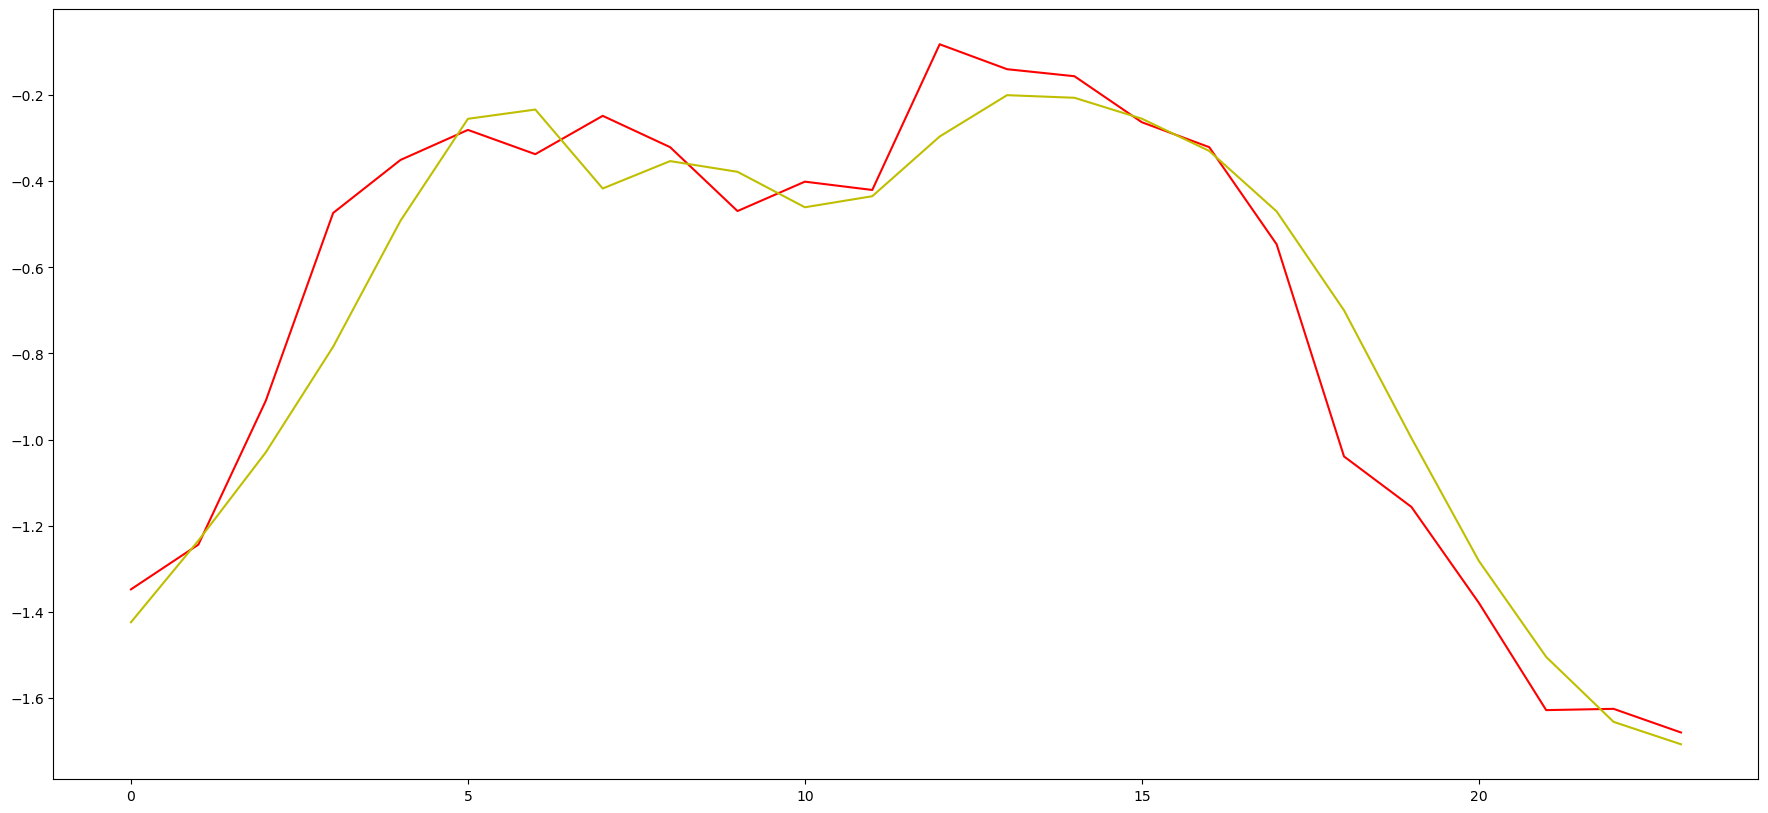

In [23]:
plot(y_true, y_pred)